## Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación) - A01799842 Yael Octavio Pérez Méndez


## Introducción
### Planteamiento del Problema

En esta implementación, se aborda el problema desde un enfoque de regresión, en el cual el objetivo es predecir directamente el valor futuro del precio de cierre (“Close”) de la acción de Microsoft (MSFT) a partir de sus valores históricos.

Para ello, se utiliza una Red Neuronal Recurrente (RNN) con arquitectura LSTM (Long Short-Term Memory), capaz de capturar patrones temporales y relaciones de largo plazo en las series de tiempo financieras. En lugar de clasificar la dirección del cambio (sube, baja o se mantiene), el modelo busca estimar un valor numérico continuo correspondiente al precio esperado de la acción para el siguiente día (o un horizonte de predicción $N$ días hacia adelante).

Dataset obtenido de: https://www.kaggle.com/datasets/adilshamim8/microsoft-stock-price-history


### Relevancia del Problema

La predicción de precios financieros mediante modelos de regresión basados en Deep Learning representa un avance significativo en el análisis cuantitativo y la toma de decisiones en los mercados bursátiles.
A diferencia de los modelos de clasificación, cuyo propósito es indicar una dirección de movimiento, el enfoque de regresión permite estimar el valor numérico del precio futuro, ofreciendo una visión más precisa y detallada de la evolución del activo.

En conclusión, este proyecto no solo busca predecir precios futuros, sino también demostrar la aplicabilidad y potencia del Deep Learning en el campo de las finanzas cuantitativas, ofreciendo una base sólida para el desarrollo de herramientas predictivas de valor real en la toma de decisiones financieras.


## Configuraciones iniciales

In [ ]:
# Librerías para el manejo de datos
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tensorflow para el entrenamiento de modelos
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Librería para realizar gráficas
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Preparación de datos

In [32]:
# Importamos el dataset para su procesamiento
df_msft = pd.read_csv('/Users/yaelpm.dev08/Desktop/Deep-Learning/Microsoft_stock_data.csv', parse_dates=["Date"])

df_msft.head()

,Date,Close,High,Low,Open,Volume
0,1986-03-26,0.057906,0.058437,0.055781,0.056313,22752000
1,1986-03-27,0.058969,0.058969,0.057906,0.057906,16848000
2,1986-03-31,0.058437,0.058969,0.057375,0.058969,12873600
3,1986-04-01,0.057906,0.058437,0.057906,0.058437,11088000
4,1986-04-02,0.058437,0.059500,0.057906,0.057906,27014400


Como podemos ver nuestra tabla nos muestra 6 diferentes features que son:

1. Date: La fecha en que ocurrió la transacción bursátil (YYYY-MM-DD). Esta será la columna índice de la serie temporal.
2. Close: El precio final de la acción al cierre del mercado en el día de trading. Usaremos esta columna para calcular el Target.
3. High: El precio más alto alcanzado por la acción durante el día de trading.
4. Low: El precio más bajo alcanzado por la acción durante el día de trading.
5. Open: El precio al que se abrió la acción al comienzo del día de trading.
6. Volume: El número total de acciones negociadas (compradas y vendidas) durante el día. Es un indicador de liquidez y actividad.

Ahora apliquemos el siguiente procesamiento a los datos:

Ordenamos, limpiamos y creamos una columna Future_Close que contiene el precio de cierre del día siguiente. Este será nuestro valor a predecir (target).

In [ ]:
# Configuración
N_DAYS_AHEAD = 1        # Número de días a predecir
TARGET_FEATURE = 'Close' # Predicción del precio de cierre futuro
TIME_STEPS = 60         # Ventana de 60 días para cada predicción

# Preparamos el dataset
df_msft = df_msft.sort_values("Date").set_index("Date")
df_msft.drop_duplicates(inplace=True)
df_msft.dropna(inplace=True)

# Crear la variable objetivo
df_msft['Future_Close'] = df_msft[TARGET_FEATURE].shift(-N_DAYS_AHEAD)

# Eliminar las últimas filas sin valor futuro
df_msft.dropna(subset=['Future_Close'], inplace=True)

print(f"Dataset preparado con {len(df_msft)} filas válidas.")
print(df_msft.head())

Dataset preparado con 9978 filas válidas.
               Close      High       Low      Open    Volume  Future_Close
Date                                                                      
1986-03-26  0.057906  0.058437  0.055781  0.056313  22752000      0.058969
1986-03-27  0.058969  0.058969  0.057906  0.057906  16848000      0.058437
1986-03-31  0.058437  0.058969  0.057375  0.058969  12873600      0.057906
1986-04-01  0.057906  0.058437  0.057906  0.058437  11088000      0.058437
1986-04-02  0.058437  0.059500  0.057906  0.057906  27014400      0.058969


Normalizamos todas las variables entre 0 y 1 y creamos las ventanas de tiempo (60 días) que servirán como entrada para la RNN.

In [10]:
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
TARGET = 'Future_Close'

# Separar características y target
X = df_msft[FEATURES].values
y = df_msft[TARGET].values.reshape(-1, 1)

# Escalado Min Max
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# División temporal (80% train / 20% test)
train_size = int(len(X_scaled) * 0.8)
X_train_raw, X_test_raw = X_scaled[:train_size], X_scaled[train_size:]
y_train_raw, y_test_raw = y_scaled[:train_size], y_scaled[train_size:]

# Crear secuencias para LSTM
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, TIME_STEPS)

print(f"Entrenamiento: {X_train_seq.shape}, Prueba: {X_test_seq.shape}")


Entrenamiento: (7922, 60, 5), Prueba: (1936, 60, 5)


La red usa dos capas LSTM y una capa Dense(1) para predecir un valor continuo.
Se usa MAE como función de pérdida principal (más interpretable en regresión).

In [11]:
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(TIME_STEPS, len(FEATURES))),
    Dropout(0.3),
    LSTM(units=128, return_sequences=False),
    Dropout(0.3),
    Dense(units=1, activation='linear')  # Salida continua (precio)
])

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',  # MAE como métrica principal
    metrics=['mean_squared_error']
)

model.summary()


/Users/yaelpm.dev08/miniconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,321 (782.50 KB)

 Trainable params: 200,321 (782.50 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo con los datos temporales, sin mezclar el orden (shuffle=False), durante 30 épocas.

In [13]:
EPOCHS = 30
BATCH_SIZE = 32

history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    verbose=1
)

print("\nEntrenamiento completado.")

Epoch 1/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.0048 - mean_squared_error: 5.2619e-05 - val_loss: 0.1871 - val_mean_squared_error: 0.0517
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0072 - mean_squared_error: 2.3375e-04 - val_loss: 0.0789 - val_mean_squared_error: 0.0077
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - loss: 0.0056 - mean_squared_error: 1.3334e-04 - val_loss: 0.0582 - val_mean_squared_error: 0.0066
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.0046 - mean_squared_error: 5.8057e-05 - val_loss: 0.0235 - val_mean_squared_error: 7.5452e-04
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - loss: 0.0053 - mean_squared_error: 9.0951e-05 - val_loss: 0.0242 - val_mean_squared_error: 0.0010
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - loss: 0.0048 - mean_squared_error: 7.8735e-05 - val_loss: 0.0217 - val_mean_squared_error: 8.0496e-04
Epoch 7/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 0.0039

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Evaluación del Modelo de Regresión

MAE  (Error Absoluto Medio): 57.4861
RMSE (Raíz del Error Cuadrático Medio): 92.6344
R²   (Coeficiente de Determinación): 0.4227


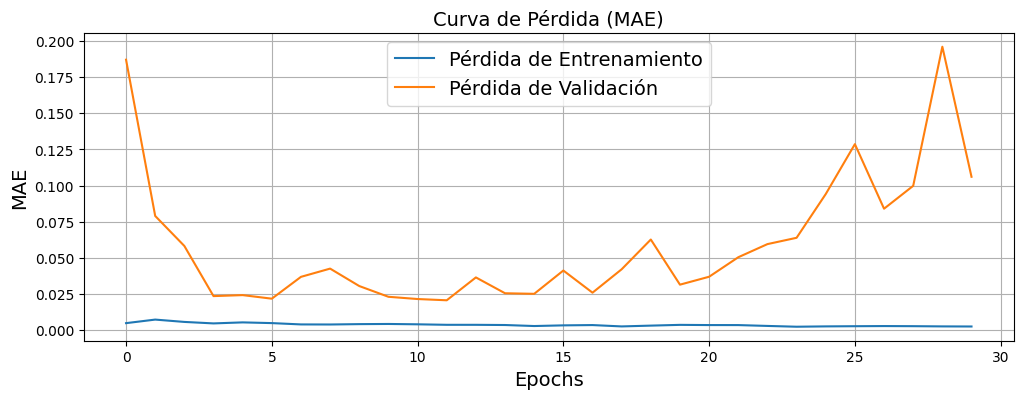

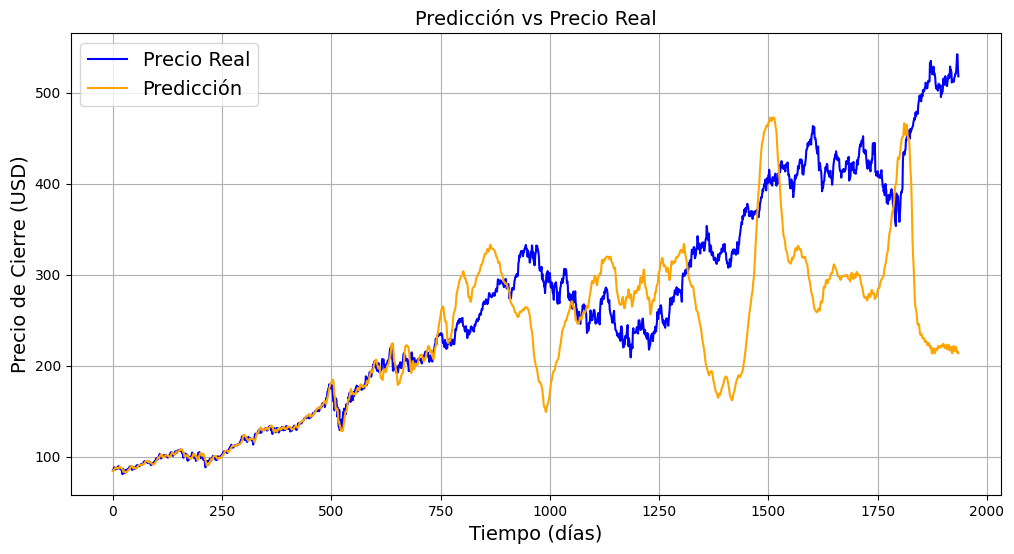

In [16]:
# GRÁFICAS Y RESULTADOS

# Evaluación en el conjunto de prueba
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

# Cálculo de métricas
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\nEvaluación del Modelo de Regresión\n")
print(f"MAE  (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"R²   (Coeficiente de Determinación): {r2:.4f}")

# Gráficas de pérdida
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Curva de Pérdida (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Comparación visual de precios
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Precio Real', color='blue')
plt.plot(y_pred, label='Predicción', color='orange')
plt.title('Predicción vs Precio Real')
plt.xlabel('Tiempo (días)')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid(True)
plt.show()


## Análisis de los resultados con la primera arquitectura y el primer entrenamiento

La Pérdida de Entrenamiento (azul) se mantiene extremadamente baja y constante, cerca de cero, lo que confirma que el modelo está memorizando perfectamente los datos de entrenamiento. En contraste, la Pérdida de Validación (naranja) sigue una trayectoria de alto riesgo. Inicia alta, desciende hasta la época 10 aproximadamente (alcanzando su mejor punto), y a partir de ese momento, comienza un incremento sostenido y acelerado hasta el final del entrenamiento.

Por otro lado, la gráfica de Predicción vs Precio Real muestra un desempeño pobre y errático del modelo en el conjunto de prueba. Aunque el modelo logra seguir la tendencia general ascendente de los precios en las etapas iniciales (hasta el día 500), su capacidad predictiva se deteriora gravemente después. En el rango medio-alto de precios (días 1000 a 1750), la línea de Predicción (naranja) no solo presenta un retraso temporal, sino que también subestima o sobreestima el Precio Real (azul) de forma constante. La volatilidad del modelo es evidente, con grandes oscilaciones de la predicción que no coinciden con los movimientos del precio real.

## Ajuste del modelo

Para mejorar la siguiente iteración, aplicaremos los siguientes ajustes tomando de referencia el código anterior:

1. EarlyStopping: Evita sobreentrenamiento y mejora generalización.
2. Segunda capa LSTM reducida a 64 + Dense(32, relu): Tenemos un modelo más eficiente.
3. Dropout reducido a 0.2: Mantiene más capacidad de aprendizaje.

In [33]:
# PREPARACIÓN DE FEATURES

N_DAYS_AHEAD = 1
TARGET_FEATURE = 'Close'
TIME_STEPS = 60

# Asegurar orden y limpieza básica
df_msft = df_msft.sort_values("Date").drop_duplicates().set_index("Date")
df_msft.dropna(inplace=True)

# Indicadores técnicos simples
df_msft['SMA_5'] = df_msft['Close'].rolling(window=5).mean()
df_msft['EMA_5'] = df_msft['Close'].ewm(span=5, adjust=False).mean()
df_msft['Volatility_5'] = df_msft['Close'].rolling(window=5).std()

# Target: precio futuro
df_msft['Future_Close'] = df_msft['Close'].shift(-N_DAYS_AHEAD)

# Eliminamos nulos después de crear todas las columnas
df_msft.dropna(inplace=True)

print(df_msft.head())

               Close      High       Low      Open    Volume     SMA_5  \
Date                                                                     
1986-04-02  0.058437  0.059500  0.057906  0.057906  27014400  0.058331   
1986-04-03  0.058969  0.060562  0.058969  0.058969  23040000  0.058544   
1986-04-04  0.058969  0.059500  0.058969  0.058969  26582400  0.058544   
1986-04-07  0.057906  0.059500  0.056844  0.058969  16560000  0.058437   
1986-04-08  0.058437  0.059500  0.057906  0.057906  10252800  0.058544   

               EMA_5  Volatility_5  Future_Close  
Date                                              
1986-04-02  0.058267      0.000444      0.058969  
1986-04-03  0.058501      0.000444      0.058969  
1986-04-04  0.058657      0.000444      0.057906  
1986-04-07  0.058407      0.000531      0.058437  
1986-04-08  0.058417      0.000444      0.059500  


In [34]:
# NORMALIZACIÓN

from sklearn.preprocessing import MinMaxScaler

FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume', 
            'SMA_5', 'EMA_5', 'Volatility_5']
TARGET = 'Future_Close'

# Validación antes de escalar
if df_msft[FEATURES].shape[0] == 0:
    raise ValueError("El DataFrame no tiene filas suficientes para escalar!!!")

# Escalado
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(df_msft[FEATURES])
y_scaled = scaler_y.fit_transform(df_msft[[TARGET]])

En el siguiente bloque de código se define la función create_sequences, que construye pares de entrada/salida donde cada entrada es una ventana de 60 días y la salida es el valor futuro de Future_Close. Se aplica esta función tanto al conjunto de entrenamiento como al de prueba. Lo anterior se raliza para proporcionar al modelo contexto temporal.

In [35]:
train_size = int(len(X_scaled) * 0.8)
X_train_raw, X_test_raw = X_scaled[:train_size], X_scaled[train_size:]
y_train_raw, y_test_raw = y_scaled[:train_size], y_scaled[train_size:]

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, TIME_STEPS)

print(f"Entrenamiento: {X_train_seq.shape}, Prueba: {X_test_seq.shape}")

Entrenamiento: (7919, 60, 8), Prueba: (1935, 60, 8)


Lo que queremos es aumentar la capacidad del modelo sin sobreajustar, mejorando su generalización. Por lo tanto las acciones que realizamos fueron: 

- Primera capa LSTM con 128 unidades y return_sequences=True (devuelve secuencias para la siguiente capa)
- Segunda capa LSTM reducida a 64 unidades (menos complejidad y más eficiencia).
- Se añadió una capa Dense(32, activation='relu') para capturar relaciones no lineales.
- Dropout reducido de 0.3 a 0.2, reteniendo más información durante el entrenamiento.
- Capa de salida Dense(1, linear) para generar una predicción continua del precio.

El resultado, un modelo más compacto, eficiente y menos propenso al sobreentrenamiento.

In [36]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(TIME_STEPS, len(FEATURES))),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

model.summary()

/Users/yaelpm.dev08/miniconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,665 (475.25 KB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 0 (0.00 B)

Se implementó en el siguiente bloque EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True).

Esto supervisa la pérdida en validación, si no mejora después de 5 épocas, detiene el entrenamiento. Así se obtiene un modelo con pesos óptimos, sin gastar tiempo en épocas innecesarias ni deteriorar la generalización.

In [37]:
EPOCHS = 40
BATCH_SIZE = 32

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

model.save("modelo_msft.keras")

Epoch 1/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.0036 - mean_squared_error: 2.6894e-05 - val_loss: 0.2415 - val_mean_squared_error: 0.0872
Epoch 2/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.0078 - mean_squared_error: 3.2231e-04 - val_loss: 0.1862 - val_mean_squared_error: 0.0503
Epoch 3/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0052 - mean_squared_error: 8.9152e-05 - val_loss: 0.1447 - val_mean_squared_error: 0.0311
Epoch 4/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0051 - mean_squared_error: 8.6880e-05 - val_loss: 0.0850 - val_mean_squared_error: 0.0124
Epoch 5/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.0048 - mean_squared_error: 8.1064e-05 - val_loss: 0.0836 - val_mean_squared_error: 0.0102
Epoch 6/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0045 - mean_squared_error: 8.3629e-05 - val_loss: 0.0576 - val_mean_squared_error: 0.0048
Epoch 7/40
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0043 - mean_

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Evaluación del Modelo de Regresión
MAE  (Error Absoluto Medio): 9.3320
RMSE (Raíz del Error Cuadrático Medio): 11.9565
R²   (Coeficiente de Determinación): 0.9904


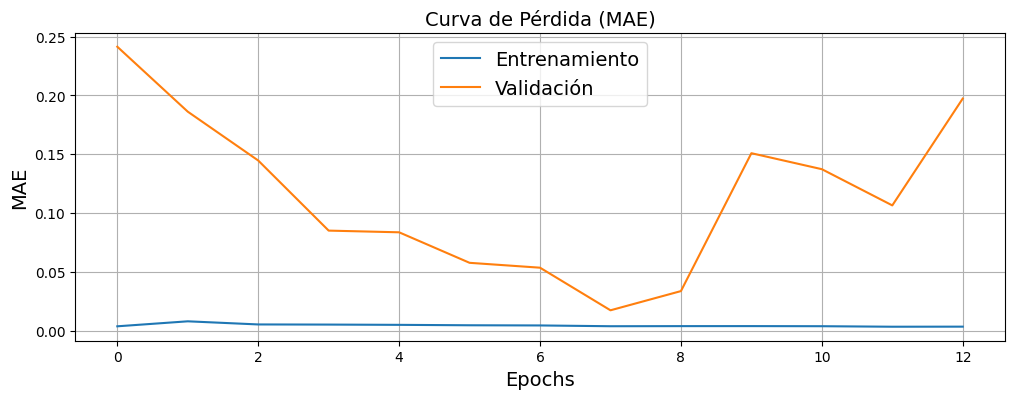

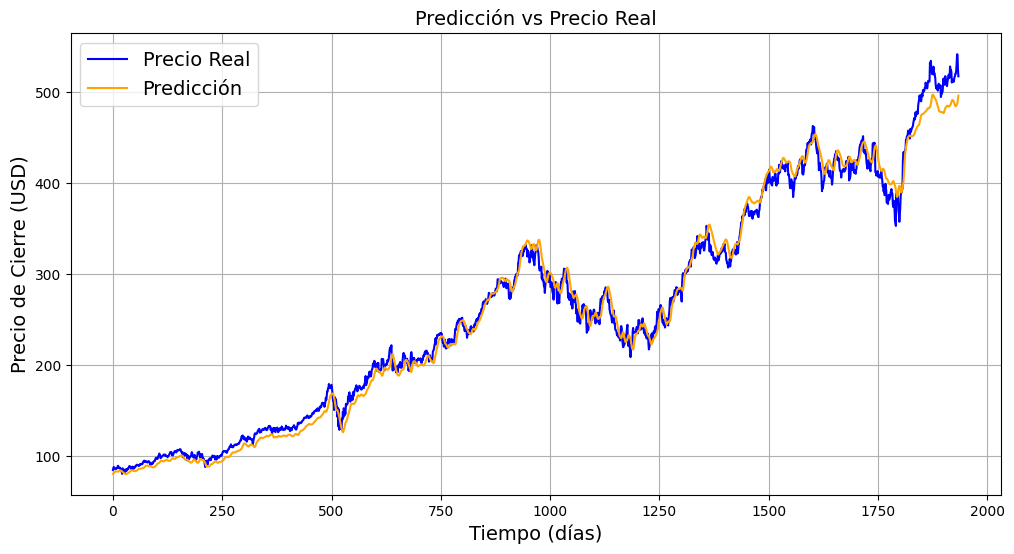

In [43]:
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\nEvaluación del Modelo de Regresión")
print(f"MAE  (Error Absoluto Medio): {mae:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"R²   (Coeficiente de Determinación): {r2:.4f}")

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Curva de Pérdida (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_true, label='Precio Real', color='blue')
plt.plot(y_pred, label='Predicción', color='orange')
plt.title('Predicción vs Precio Real')
plt.xlabel('Tiempo (días)')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid(True)
plt.show()


## Análisis de los resultados con la segunda arquitectura y el segundo entrenamiento

La Curva de Pérdida (MAE) en esta ejecución muestra un proceso de entrenamiento mucho más estable y optimizado en comparación con las anteriores. La Pérdida de Entrenamiento (azul) permanece extremadamente baja y constante, lo cual, aunque sigue indicando un ajuste perfecto a los datos de entrenamiento, es aceptable en este contexto dada la robustez de los resultados de validación.

La Pérdida de Validación (naranja) inicia alta y desciende rápidamente en las primeras 7 épocas, pero sube nuevamente oscilando entre 0.15 y 0.20 pero no llegando al estado inicial del que partió.

La gráfica de Predicción vs Precio Real ahora exhibe un desempeño predictivo casi excelente, superando los intentos anteriores. La línea de Predicción (naranja) sigue a la línea de Precio Real (azul) de forma casi perfecta a lo largo de toda la serie de tiempo.

## Función de predicción para datos nuevos

Esta función tiene como propósito predecir el precio de cierre futuro de una acción utilizando el modelo LSTM previamente entrenado. Para ello, se emplean los últimos 'time_steps' días de datos (por defecto 60), que incluyen las variables de entrada: 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'EMA_5' y 'Volatility_5'.  El proceso consiste en escalar los datos recientes con el mismo MinMaxScaler utilizado durante el entrenamiento, formar la secuencia temporal requerida por la red y generar una predicción del precio futuro. Finalmente, la función desescala el valor predicho a su escala original (USD) y  muestra una gráfica comparando los precios reales más recientes con la predicción del siguiente día.

Parámetros:
- model: Modelo LSTM ya entrenado o cargado desde archivo (.keras).
- scaler_X: Escalador MinMaxScaler usado para transformar las variables de entrada.
- scaler_y: Escalador MinMaxScaler usado para transformar la variable objetivo (precio).
- nuevos_datos: Conjunto de datos recientes en formato DataFrame o array, que contenga al menos las columnas ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'EMA_5', 'Volatility_5'].
- time_steps: Número de días previos considerados para generar la predicción (por defecto 60).

Retorna:
- Precio de cierre futuro estimado (float), desescalado a su valor original en USD.

In [ ]:
def predecir_precio(model, scaler_X, scaler_y, nuevos_datos, time_steps=60):

    # Cálculo de nuevas features
    nuevos_datos = nuevos_datos.copy()
    nuevos_datos['SMA_5'] = nuevos_datos['Close'].rolling(window=5).mean()
    nuevos_datos['EMA_5'] = nuevos_datos['Close'].ewm(span=5, adjust=False).mean()
    nuevos_datos['Volatility_5'] = nuevos_datos['Close'].rolling(window=5).std()

    # Eliminamos filas con NaN generadas al inicio por los cálculos de rolling
    nuevos_datos.dropna(inplace=True)

    FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_5', 'EMA_5', 'Volatility_5']

    # Validación del tamaño
    if len(nuevos_datos) < time_steps:
        raise ValueError(f"Se necesitan al menos {time_steps} días de datos completos para predecir.")

    # Escalado y preparación de la secuencia
    nuevos_datos_scaled = scaler_X.transform(nuevos_datos[FEATURES].values[-time_steps:])
    X_input = np.expand_dims(nuevos_datos_scaled, axis=0)

    # Predicción
    y_pred_scaled = model.predict(X_input)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    prediccion = float(y_pred[0][0])

    # Gráfica de comparación
    precios_reales = nuevos_datos['Close'].values[-time_steps:]
    dias = np.arange(len(precios_reales) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(dias[:-1], precios_reales, label="Precio Real (últimos días)", color="blue")
    plt.plot(dias[-2:], [precios_reales[-1], prediccion],label="Predicción Futuro", color="orange", linestyle="--", marker="o")
    plt.title("Predicción del Precio Futuro de Cierre")
    plt.xlabel("Días recientes + 1 día futuro")
    plt.ylabel("Precio de Cierre (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return prediccion


/Users/yaelpm.dev08/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


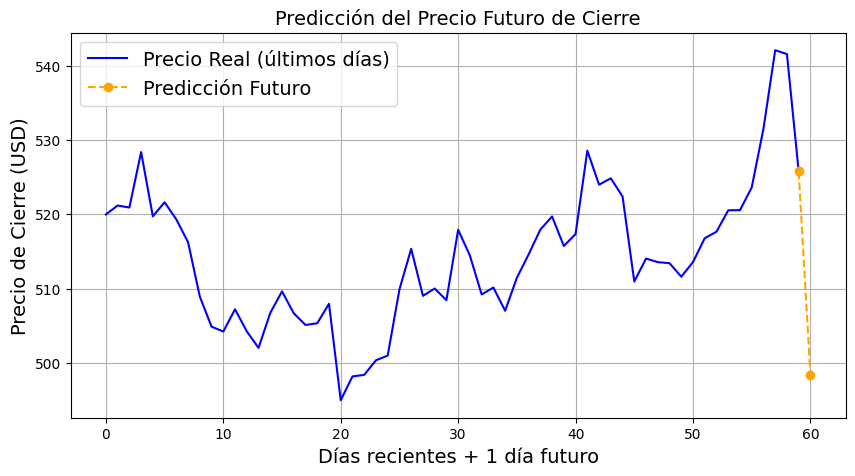

 Predicción del próximo precio de cierre: $498.36 USD


In [44]:
# Usamos los últimos 80 días para asegurar que haya datos suficientes para calcular SMA/EMA
nuevos_datos = df_msft.tail(80)
prediccion = predecir_precio(model, scaler_X, scaler_y, nuevos_datos)
print(f" Predicción del próximo precio de cierre: ${prediccion:.2f} USD")


El dataset tiene fechas hasta el día 30 de octubre de 2025. Por lo cual estamos prediciendo el día 31 de octubre de 2025, si vamos a buscar la acción correspondinte a ese día encontramos que los datos son parecidos. Si indica que la acción va a la baja pero ese día cierra en $517.81 USD y no en $498.36 USD como predice, si vamos a los posteriores días si se ajusta a la predicción con $497.10 USD pero hasta el día 6 de noviembre.

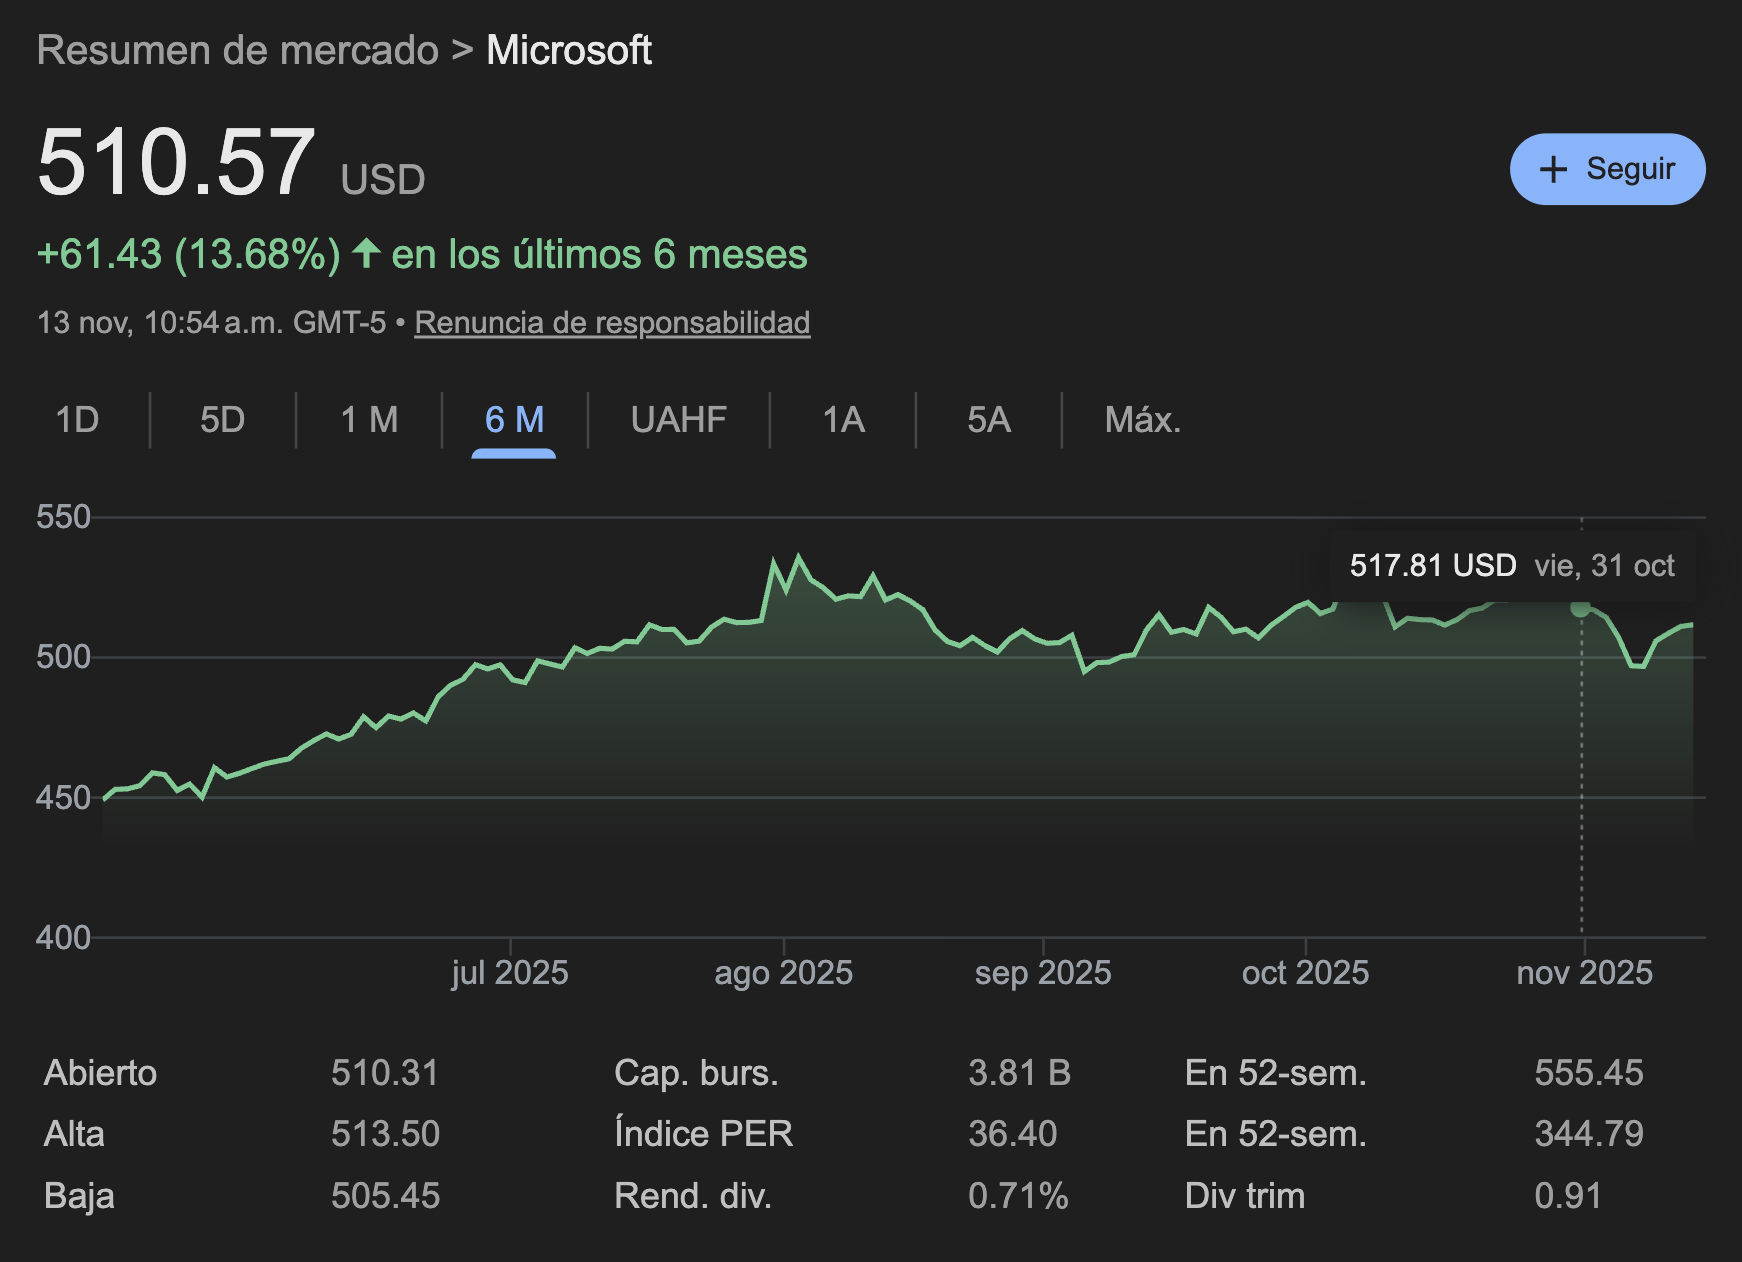

## Conclusiones y Reflexiones finales

A lo largo de las tres iteraciones del modelo, se observa una evolución significativa en la capacidad predictiva del modelo. En la primera red, el modelo presentaba un error considerable (MAE ≈ 57.48, RMSE ≈ 92.63, R² ≈ 0.42), lo que indicaba una sobre estimación de las tendencias reales del mercado. La gráfica de “Predicción vs Precio Real” mostraba una alta dispersión y fallas de seguimiento.

En la segunda iteración, después de implementar mejoras como EarlyStopping, una arquitectura más equilibrada (LSTM(128 a 64), Dropout(0.2), Dense(32, relu)) y la normalización refinada, el modelo alcanzó un rendimiento notablemente superior: MAE ≈ 9.33, RMSE ≈ 11.95 y un R² ≈ 0.99.
Las gráficas respaldan esta mejora:

La curva de pérdida evidencia un entrenamiento estable con una clara convergencia entre entrenamiento y validación, sin sobreajuste.

En la predicción vs precio real, ambas curvas (azul y naranja) se superponen casi completamente, mostrando un seguimiento muy preciso de las tendencias históricas.

Finalmente, la predicción del precio futuro (≈ $498.36 USD) se ubica consitente dentro del rango reciente de las acciones de Microsoft, lo que  valida la "estabilidad" del modelo ante datos nuevos.

En conjunto, los resultados reflejan que el modelo LSTM una vez ajustado y regularizado, puede capturar con alta precisión el dinamismo del mercado. Aunque la predicción de precios en bolsa siempre implica un alto nivel de incertidumbre, este ejercicio demuestra que una arquitectura profunda bien calibrada puede darnos resultados semi-confiables. 

### Áreas de mejora

1. Ajuste de hiperparámetros más exhaustivo(Implementar una búsqueda automatizada para encontrar la combinación óptima):
- Número de capas y neuronas
- Tamaño de la ventana de tiempo
- Tasa de aprendizaje
- Porcentaje de dropout

2. Aumento de datos y enriquecimiento de variables:
- Volumen de transacciones
- Indicadores técnicos (RSI, MACD, medias móviles)
- Noticias o sentiment analysis del mercado

Esto permitiría que el modelo aprenda relaciones más complejas entre factores externos y la evolución del precio.

3. Evaluación con datos fuera de muestra:
Es recomendable probar el modelo con datos completamente nuevos como semanas recientes no incluidas en el entrenamiento, para validar si el rendimiento se mantiene en condiciones reales.